In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [2]:
import os

# to disable GPU support
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# fix/hack for CUDA: https://github.com/tensorflow/tensorflow/issues/41987
#                    https://www.gitmemory.com/issue/tensorflow/tensorflow/41993/668082420
os.environ['TF_CUDNN_RESET_RND_GEN_STATE'] = '1'

# code inspired from:
# 1. https://www.kaggle.com/mineshjethva/timeseries-anomaly-detection-using-rnn-autoencoder/comments
# 2. https://www.kaggle.com/koheimuramatsu/industrial-machine-anomaly-detection

# 1. Read Raw Data

## 1.1. Artificial Data

In [3]:
url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
small_noise_url = url_root + small_noise_url_suffix
df_small_noise = pd.read_csv(small_noise_url)

daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
daily_jumpsup_url = url_root + daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(daily_jumpsup_url)

In [4]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


## 1.2. Real Data

In [5]:
aws_url_suffix = "realKnownCause/ec2_request_latency_system_failure.csv"
aws_latency_data_url = url_root + aws_url_suffix
df_aws_latency = pd.read_csv(aws_latency_data_url)

In [6]:
df_aws_latency.head()

,timestamp,value
0,2014-03-07 03:41:00,45.868
1,2014-03-07 03:46:00,47.606
2,2014-03-07 03:51:00,42.580
3,2014-03-07 03:56:00,46.030
4,2014-03-07 04:01:00,44.992


In [7]:
# AWS "realKnownCause/ec2_request_latency_system_failure.csv"
# data from: https://github.com/numenta/NAB/blob/master/labels/combined_windows.json
anomalies = [
    [
        "2014-03-14 03:31:00.000000",
        "2014-03-14 14:41:00.000000"
    ],
    [
        "2014-03-18 17:06:00.000000",
        "2014-03-19 04:16:00.000000"
    ],
    [
        "2014-03-20 21:26:00.000000",
        "2014-03-21 03:41:00.000000"
    ]
]

# 2. Visualization

In [8]:
def plot_variance(df, agg_type='day'):
    df_copy = df.copy(deep=True)
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    df_copy['year'] = df_copy['timestamp'].apply(lambda x: x.year)
    df_copy['month'] = df_copy['timestamp'].apply(lambda x: x.month)
    df_copy['day'] = df_copy['timestamp'].apply(lambda x: x.day)
    df_copy['hour'] = df_copy['timestamp'].apply(lambda x: x.hour)
    df_copy['minute'] = df_copy['timestamp'].apply(lambda x: x.minute)

    stat = df_copy.groupby([agg_type]).agg({'value': ['var']})['value']
    stat.plot(kind='bar', figsize=(20,5))

## 2.1. Artificial Data

### 2.1.1. Without outliers

<AxesSubplot:>

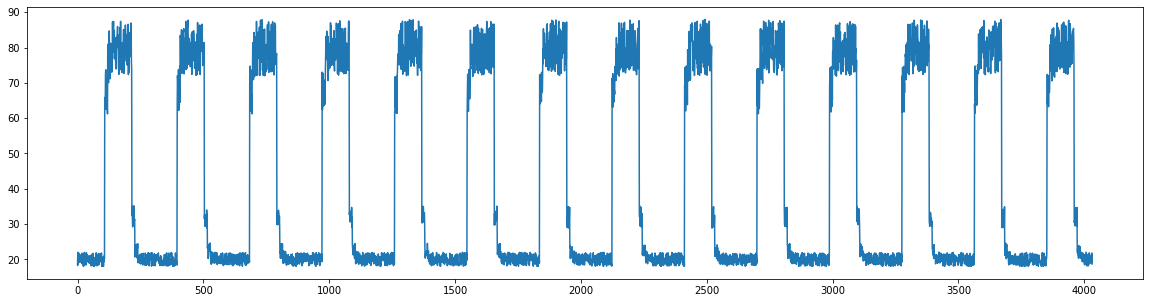

In [9]:
df_small_noise.value.plot(figsize=(20,5))

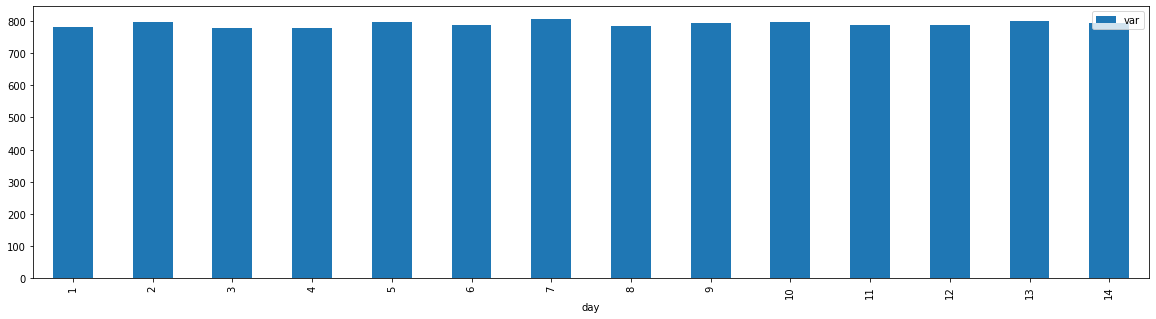

In [10]:
plot_variance(df_small_noise)

### 2.1.2. With outliers

<AxesSubplot:>

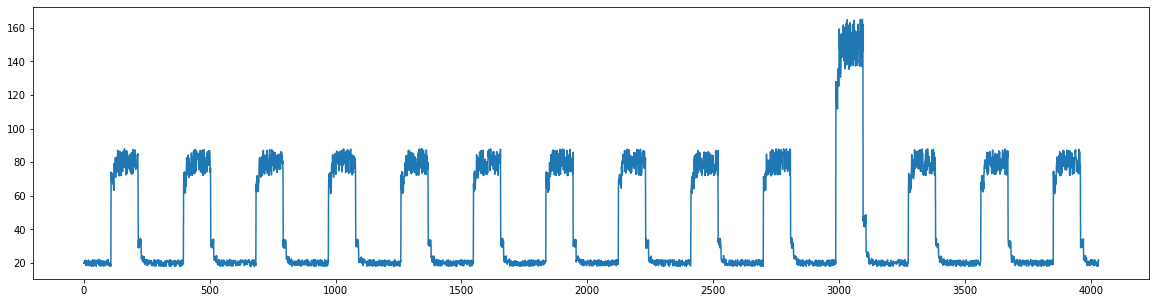

In [11]:
df_daily_jumpsup.value.plot(figsize=(20,5))

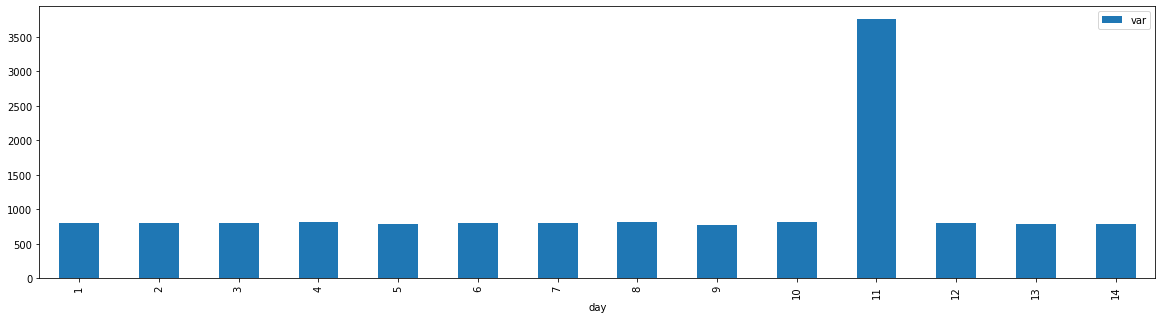

In [12]:
plot_variance(df_daily_jumpsup)

## 2.2. Real Data

### 2.2.1. Zoom-OUT

<AxesSubplot:>

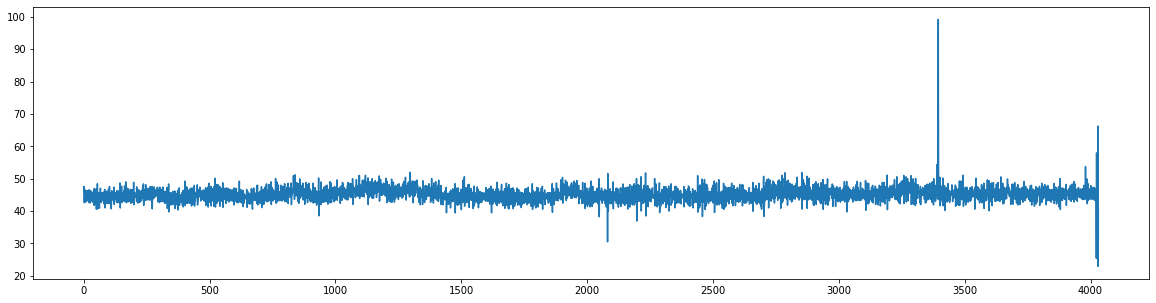

In [13]:
df_aws_latency.value.plot(figsize=(20,5))

### 2.2.2. Zoom-IN

#### 1st interval with anomalies

<AxesSubplot:>

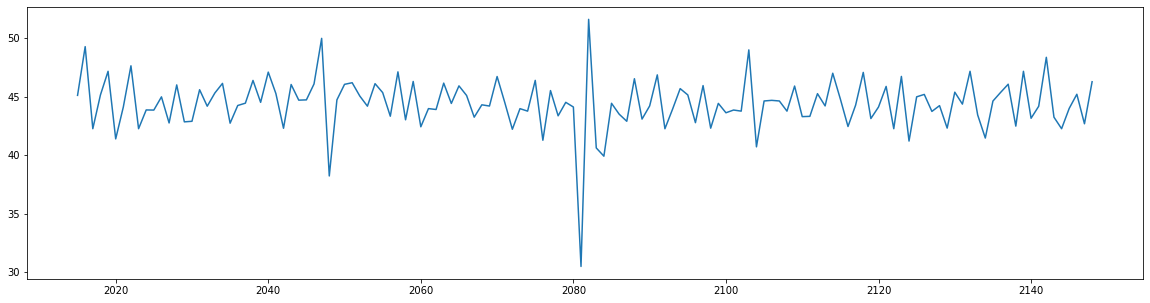

In [14]:
mask_anomaly1 = (df_aws_latency['timestamp'] > anomalies[0][0]) & (df_aws_latency['timestamp'] <= anomalies[0][1])
df_aws_latency.loc[mask_anomaly1].value.plot(figsize=(20,5))

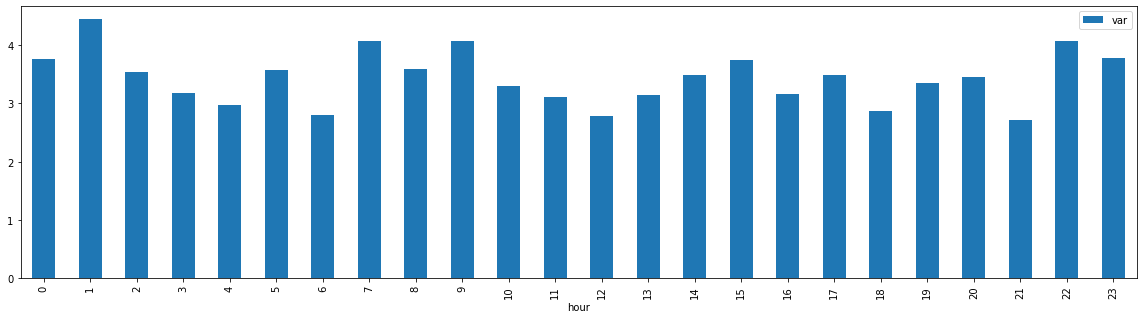

In [15]:
mask_before_anomaly1 = df_aws_latency['timestamp'] < anomalies[0][0]
plot_variance(df_aws_latency.loc[mask_before_anomaly1], agg_type='hour')

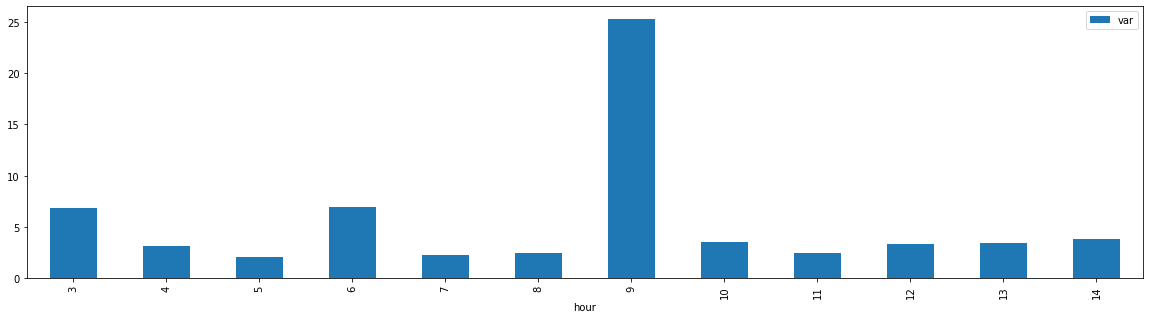

In [16]:
plot_variance(df_aws_latency.loc[mask_anomaly1], agg_type='hour')

#### 2nd interval with anomalies

<AxesSubplot:>

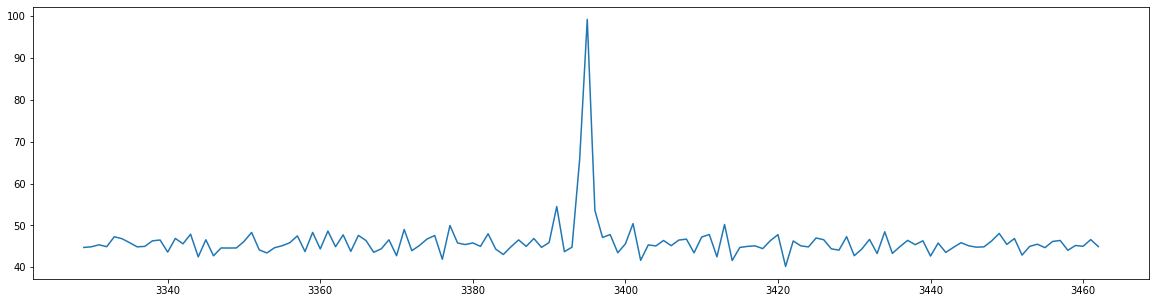

In [17]:
mask_anomaly2 = (df_aws_latency['timestamp'] > anomalies[1][0]) & (df_aws_latency['timestamp'] <= anomalies[1][1])
df_aws_latency.loc[mask_anomaly2].value.plot(figsize=(20,5))

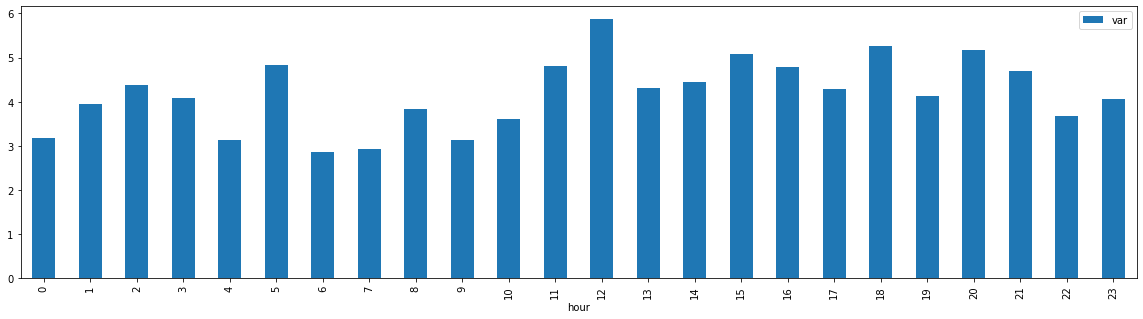

In [18]:
mask_between_anomaly1_and_2 = (df_aws_latency['timestamp'] > anomalies[0][1]) & (df_aws_latency['timestamp'] <= anomalies[1][0])
plot_variance(df_aws_latency.loc[mask_between_anomaly1_and_2], agg_type='hour')

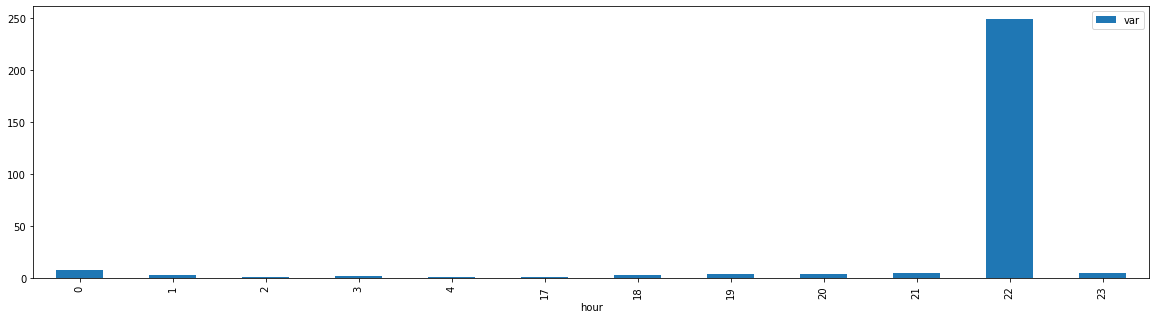

In [19]:
plot_variance(df_aws_latency.loc[mask_anomaly2], agg_type='hour')

#### 3rd interval with anomalies

<AxesSubplot:>

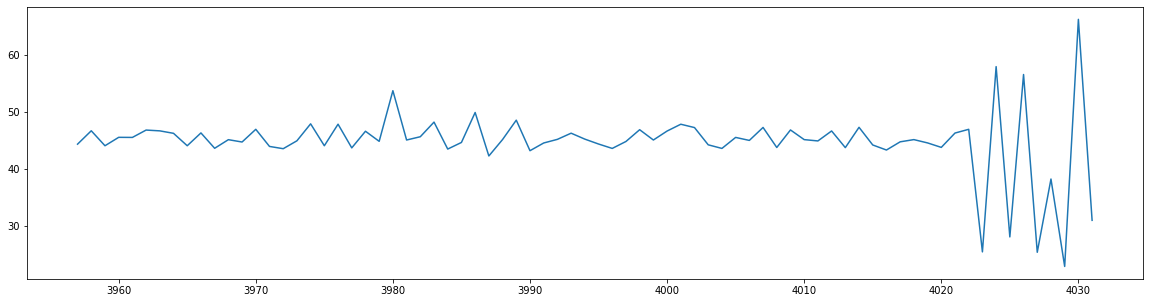

In [20]:
mask_anomaly3 = (df_aws_latency['timestamp'] > anomalies[2][0]) & (df_aws_latency['timestamp'] <= anomalies[2][1])
df_aws_latency.loc[mask_anomaly3].value.plot(figsize=(20,5))

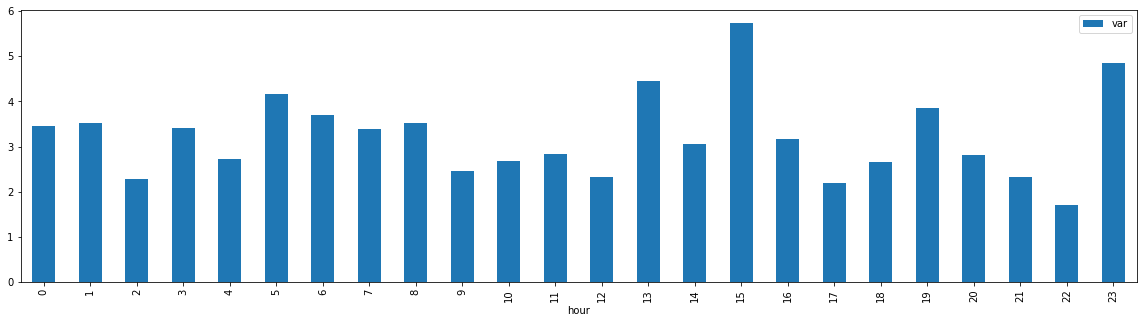

In [21]:
mask_between_anomaly2_and_3 = (df_aws_latency['timestamp'] > anomalies[1][1]) & (df_aws_latency['timestamp'] <= anomalies[2][0])
plot_variance(df_aws_latency.loc[mask_between_anomaly2_and_3], agg_type='hour')

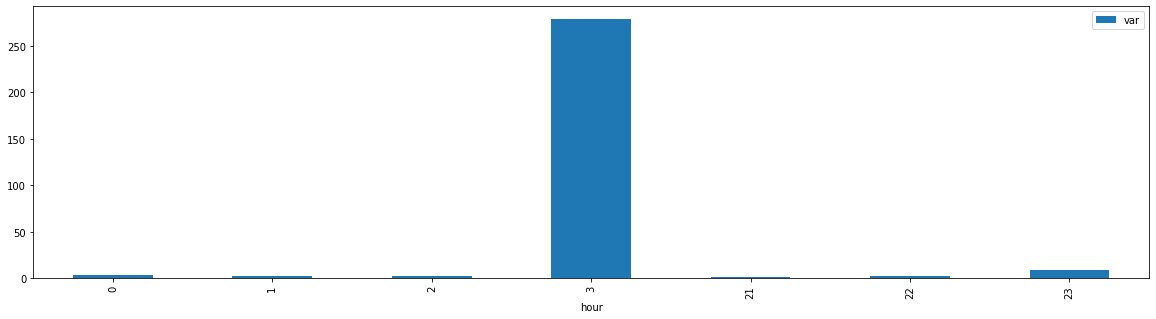

In [22]:
plot_variance(df_aws_latency.loc[mask_anomaly3], agg_type='hour')

# 3. Anomaly Types

## 3.1. Additive Outliers

In [23]:
df_aditive_outliers = df_small_noise.head(1000).copy()
additive_anomaly = (df_aditive_outliers['value'] == df_aditive_outliers.value.at[850])
df_aditive_outliers.value.at[850] = df_aditive_outliers.value.at[850] + 100

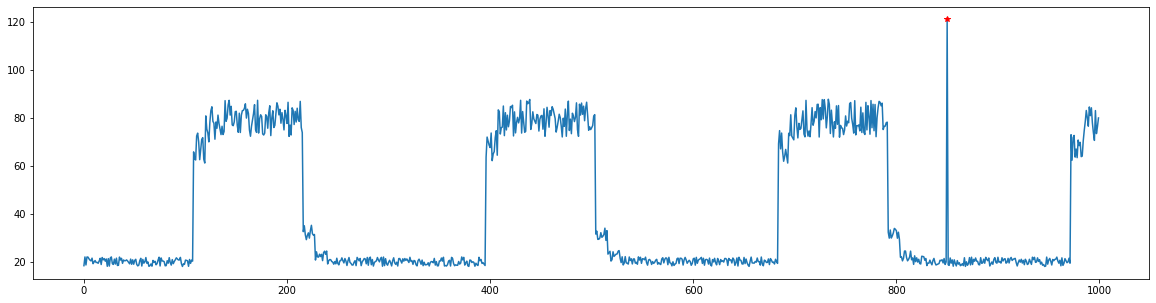

In [24]:
fig, ax = plt.subplots()
ax = df_aditive_outliers.value.plot(figsize=(20,5))
ax = df_aditive_outliers.loc[additive_anomaly].value.plot(figsize=(20,5), color='red', style='*')
plt.show()

## 3.2. Level-shift Outliers

In [25]:
df_level_shift_outliers = df_small_noise.head(1000).copy()
level_shift_anomaly = (df_aditive_outliers.index > 600)
cols = ['value']
df_level_shift_outliers.loc[level_shift_anomaly, cols] = df_level_shift_outliers[cols] * 3

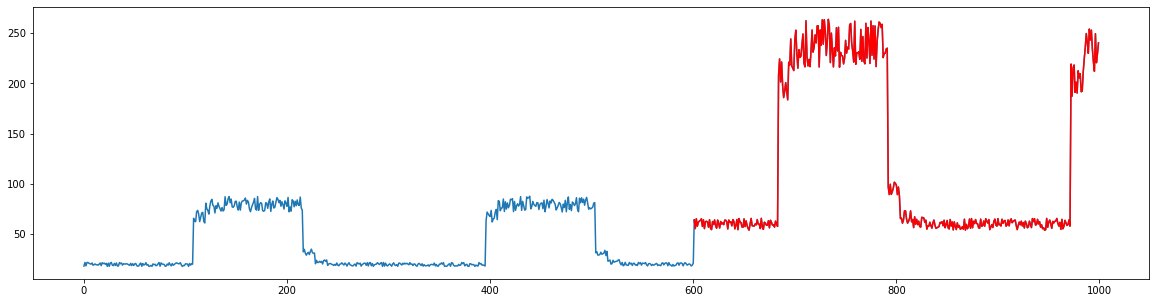

In [26]:
fig, ax = plt.subplots()
ax = df_level_shift_outliers.value.plot(figsize=(20,5))
ax = df_level_shift_outliers.loc[level_shift_anomaly].value.plot(figsize=(20,5), color='red')
plt.show()

## 3.3. Transient Change Outliers

In [27]:
df_level_transient_change_outliers = df_small_noise.head(1000).copy()
transient_change_anomaly = (df_level_transient_change_outliers.index >= 600) & (df_level_transient_change_outliers.index < 650)
cols = ['value']

def exp_reduce(values):
    res = []
    for idx, v in enumerate(values):
        if idx >= 600:
            i = idx - 600
            rv = v + v * abs(1-np.exp(1/(i+1)))
            res.append(rv)
        else:
            res.append(v)
#         print(i)
    return res

df_level_transient_change_outliers.loc[transient_change_anomaly, cols] = df_level_transient_change_outliers[cols].apply(exp_reduce)

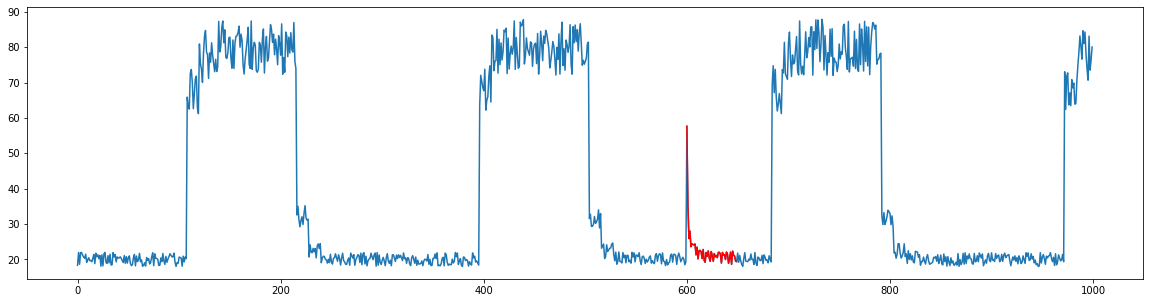

In [28]:
fig, ax = plt.subplots()
ax = df_level_transient_change_outliers.value.plot(figsize=(20,5))
ax = df_level_transient_change_outliers.loc[transient_change_anomaly].value.plot(figsize=(20,5), color='red')
plt.show()

## 3.4. Local Trend Outlier

In [29]:
df_level_local_trend_outliers = df_small_noise.head(1000).copy()
local_trend_anomaly = (df_level_local_trend_outliers.index >= 600) & (df_level_local_trend_outliers.index < 650)
cols = ['value']

def exp_reduce(values):
    res = []
    for idx, v in enumerate(values):
        if idx >= 600:
            i = idx - 600
            rv = v + 40 + idx - 600
            res.append(rv)
        else:
            res.append(v)
#         print(i)
    return res

df_level_local_trend_outliers.loc[local_trend_anomaly, cols] = df_level_local_trend_outliers[cols].apply(exp_reduce)

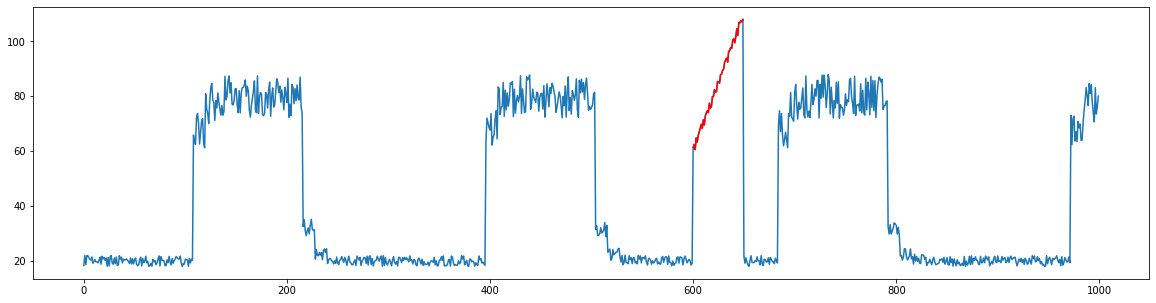

In [30]:
fig, ax = plt.subplots()
ax = df_level_local_trend_outliers.value.plot(figsize=(20,5))
ax = df_level_local_trend_outliers.loc[local_trend_anomaly].value.plot(figsize=(20,5), color='red')
plt.show()

## 3.5. Seasonal Additive Outlier

In [31]:
df_seasonal_aditive_outliers = df_small_noise.head(1000).copy()
vals = [df_seasonal_aditive_outliers.value.at[150], df_seasonal_aditive_outliers.value.at[450]]
seasonal_additive_anomaly = (df_seasonal_aditive_outliers['value'] == df_seasonal_aditive_outliers.value.at[150]) | \
                            (df_seasonal_aditive_outliers['value'] == df_seasonal_aditive_outliers.value.at[450]) | \
                            (df_seasonal_aditive_outliers['value'] == df_seasonal_aditive_outliers.value.at[750])
df_seasonal_aditive_outliers.value.at[150] = df_seasonal_aditive_outliers.value.at[150] + 100
df_seasonal_aditive_outliers.value.at[450] = df_seasonal_aditive_outliers.value.at[450] + 100
df_seasonal_aditive_outliers.value.at[750] = df_seasonal_aditive_outliers.value.at[750] + 100

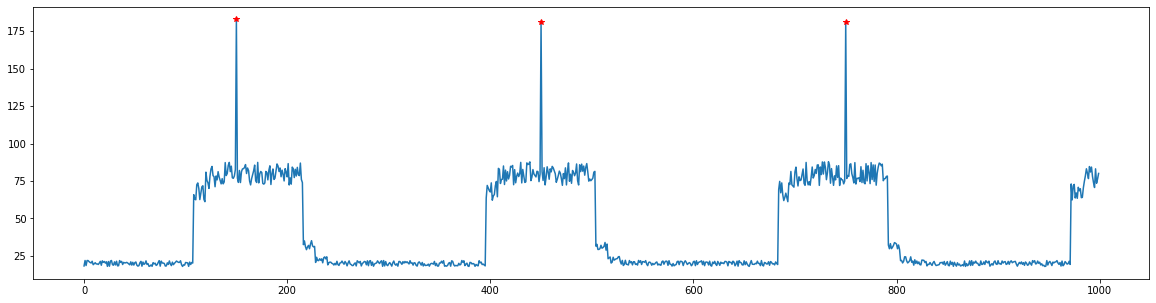

In [32]:
fig, ax = plt.subplots()
ax = df_seasonal_aditive_outliers.value.plot(figsize=(20,5))
ax = df_seasonal_aditive_outliers.loc[seasonal_additive_anomaly].value.plot(figsize=(20,5), color='red', style='*')
plt.show()

## 3.5. Real Machinery Anomalies

### 3.5.1. Load Data

In [33]:
data_machinery_url_suffix = "realKnownCause/machine_temperature_system_failure.csv"
data_machinery_url = url_root + data_machinery_url_suffix
df_machinery = pd.read_csv(data_machinery_url)

In [34]:
df_machinery.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


<AxesSubplot:>

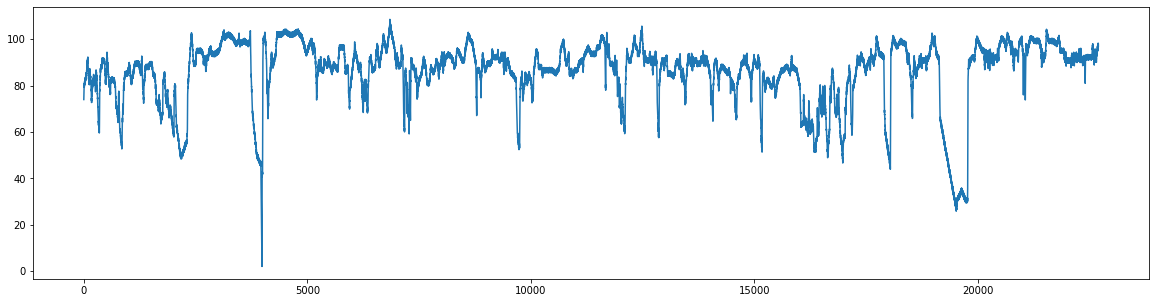

In [35]:
df_machinery.value.plot(figsize=(20,5))

### 3.5.1. Anomalies

In [36]:
anomalies_machinery = [
    [
        "2013-12-10 06:25:00.000000",
        "2013-12-12 05:35:00.000000"
    ],
    [
        "2013-12-15 17:50:00.000000",
        "2013-12-17 17:00:00.000000"
    ],
    [
        "2014-01-27 14:20:00.000000",
        "2014-01-29 13:30:00.000000"
    ],
    [
        "2014-02-07 14:55:00.000000",
        "2014-02-09 14:05:00.000000"
    ]
]

In [37]:
mask_machinery_anomaly1 = (df_machinery['timestamp'] > anomalies_machinery[0][0]) & (df_machinery['timestamp'] <= anomalies_machinery[0][1])
mask_machinery_anomaly2 = (df_machinery['timestamp'] > anomalies_machinery[1][0]) & (df_machinery['timestamp'] <= anomalies_machinery[1][1])
mask_machinery_anomaly3 = (df_machinery['timestamp'] > anomalies_machinery[2][0]) & (df_machinery['timestamp'] <= anomalies_machinery[2][1])
mask_machinery_anomaly4 = (df_machinery['timestamp'] > anomalies_machinery[3][0]) & (df_machinery['timestamp'] <= anomalies_machinery[3][1])

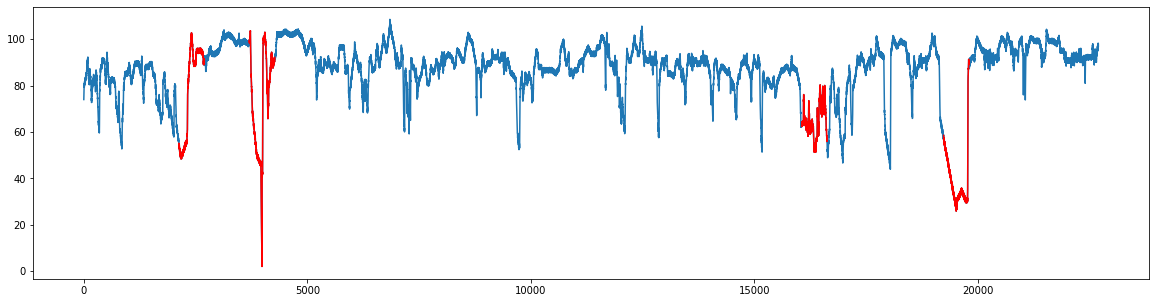

In [38]:
fig, ax = plt.subplots()

# df_machinery.loc[mask_machinery_anomaly1].value.plot(figsize=(20,5))

ax = df_machinery.value.plot(figsize=(20,5))
ax = df_machinery.loc[mask_machinery_anomaly1].value.plot(figsize=(20,5), color='red')
ax = df_machinery.loc[mask_machinery_anomaly2].value.plot(figsize=(20,5), color='red')
ax = df_machinery.loc[mask_machinery_anomaly3].value.plot(figsize=(20,5), color='red')
ax = df_machinery.loc[mask_machinery_anomaly4].value.plot(figsize=(20,5), color='red')

# plt.legend(loc='best')
plt.show()

### 3.5.3. Detect Anomalies Using Variance

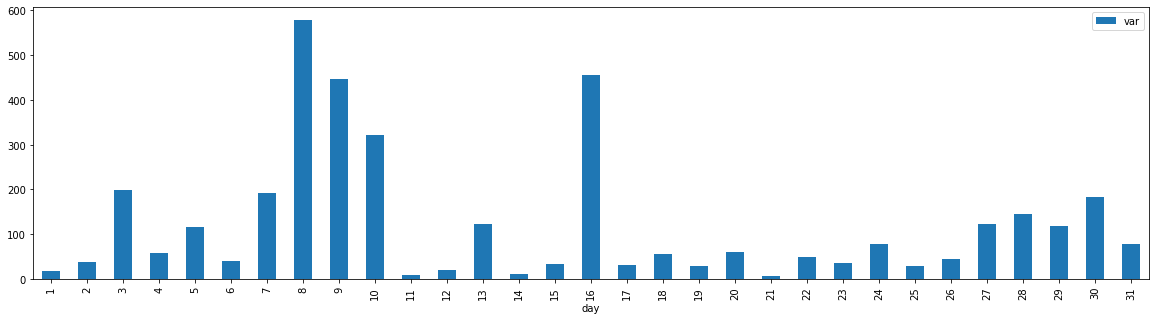

In [39]:
plot_variance(df_machinery, agg_type='day')

In [40]:
mask_machinery_before_anomaly1 = df_machinery['timestamp'] < anomalies_machinery[0][0]
mask_machinery_before_and_during_anomaly1 = df_machinery['timestamp'] <= anomalies_machinery[0][1]

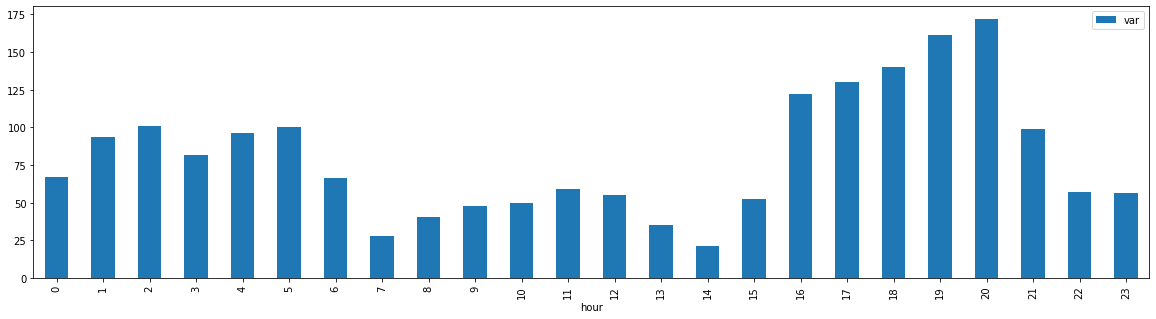

In [41]:
plot_variance(df_machinery.loc[mask_machinery_before_anomaly1], agg_type='hour')

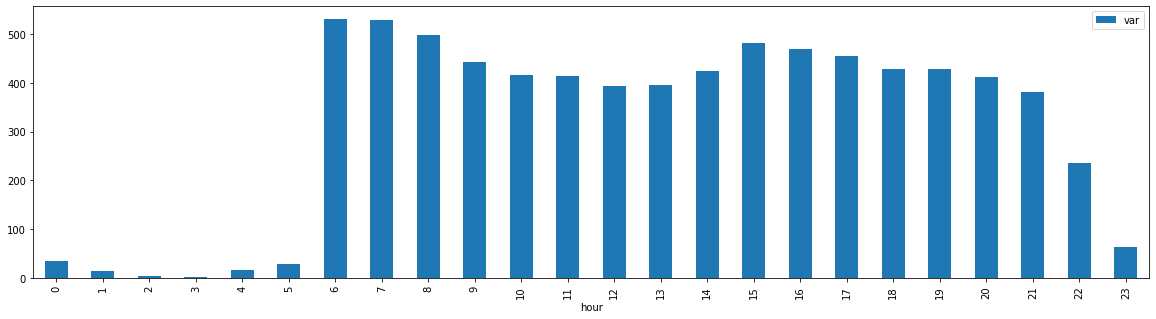

In [42]:
plot_variance(df_machinery.loc[mask_machinery_anomaly1], agg_type='hour')

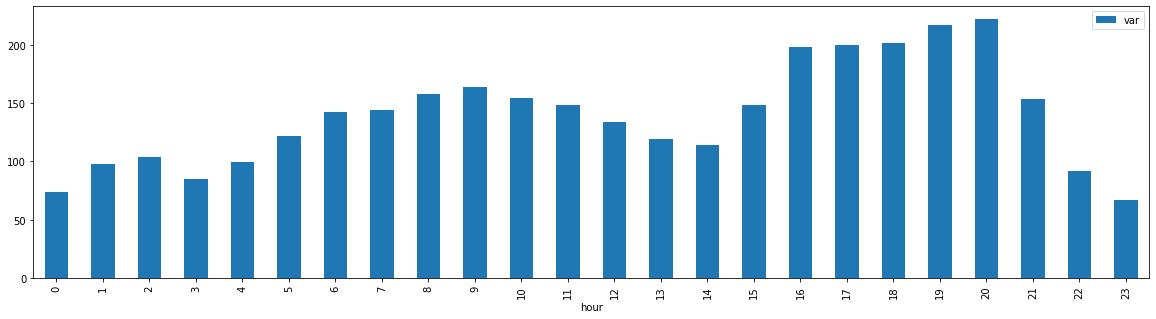

In [43]:
plot_variance(df_machinery.loc[mask_machinery_before_and_during_anomaly1], agg_type='hour')

# 4. Use Statistics to Detect Anomalies

## 4.1. Median Absolute Deviation

### 4.1.1. Artificial Data

In [44]:
median_a = df_daily_jumpsup.value.median()
mad_a = df_daily_jumpsup.value.mad()
print(median_a)
print(mad_a)

21.64850265575
29.240658123207023


In [45]:
anomalies_mad_a = df_daily_jumpsup[abs(df_daily_jumpsup.value - median_a) > mad_a]
anomalies_mad_a_mask = abs(df_daily_jumpsup.value - median_a) > mad_a
anomalies_mad_a.describe()

,value
count,1512.000000
mean,83.470635
std,18.798566
min,61.234296
25%,74.641558
50%,79.551611
75%,84.374652
max,164.947481


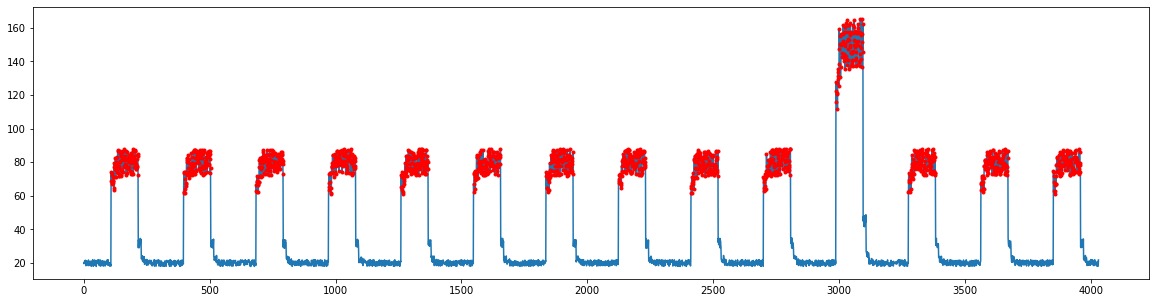

In [46]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup.value.plot(figsize=(20,5))
ax = df_daily_jumpsup.loc[anomalies_mad_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

# plt.legend(loc='best')
plt.show()

### 4.1.2. Real Data

In [47]:
median_r = df_aws_latency.value.median()
mad_r = df_aws_latency.value.mad()
print(median_r)
print(mad_r)

45.01700000000001
1.557677679014314


In [48]:
anomalies_mad_r = df_aws_latency[abs(df_aws_latency.value - median_r) > mad_r]
anomalies_mad_r_mask = abs(df_aws_latency.value - median_r) > mad_r
anomalies_mad_r.describe()

,value
count,1584.000000
mean,45.405559
std,3.481986
min,22.864000
25%,42.746000
50%,46.738000
75%,47.634000
max,99.248000


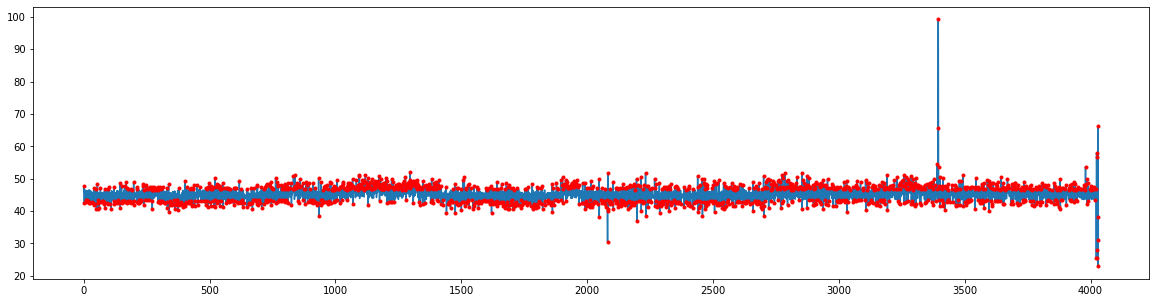

In [49]:
fig, ax = plt.subplots()

ax = df_aws_latency.value.plot(figsize=(20,5))
ax = df_aws_latency.loc[anomalies_mad_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

## 4.2. Interquartile Range

### 4.2.1. Artificial Data

In [50]:
q1_a = df_daily_jumpsup.value.quantile(q=0.25)
q3_a = df_daily_jumpsup.value.quantile(q=0.75)
iqr_a = q3_a - q1_a
l_threshold_a = q1_a - 1.5 * iqr_a
h_threshold_a = q3_a + 1.5 * iqr_a

In [51]:
print('Q1={}, Q3={}, IQR={}, L_THR={}, H_THR={}'.format(q1_a, q3_a, iqr_a, l_threshold_a, h_threshold_a))

Q1=19.99138176275, Q3=76.43594258925, IQR=56.44456082650001, L_THR=-64.67545947700002, H_THR=161.10278382900003


In [52]:
anomalies_iqr_a = df_daily_jumpsup[df_daily_jumpsup.value > h_threshold_a]
anomalies_iqr_a_mask = df_daily_jumpsup.value > h_threshold_a
anomalies_iqr_a.describe()

,value
count,12.000000
mean,162.888561
std,1.439290
min,161.349096
25%,161.719147
50%,162.331918
75%,164.436694
max,164.947481


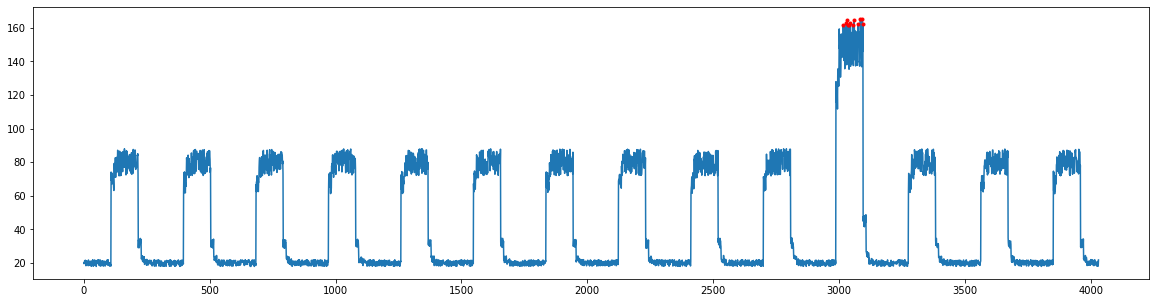

In [53]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup.value.plot(figsize=(20,5))
ax = df_daily_jumpsup.loc[anomalies_iqr_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.2.2. Real Data

In [54]:
q1_r = df_aws_latency.value.quantile(q=0.25)
q3_r = df_aws_latency.value.quantile(q=0.75)
iqr_r = q3_r - q1_r
l_threshold_r = q1_r - 1.5 * iqr_r
h_threshold_r = q3_r + 1.5 * iqr_r

In [55]:
print('Q1={}, Q3={}, IQR={}, L_THR={}, H_THR={}'.format(q1_r, q3_r, iqr_r, l_threshold_r, h_threshold_r))

Q1=43.944, Q3=46.362, IQR=2.4179999999999993, L_THR=40.31700000000001, H_THR=49.989000000000004


In [56]:
anomalies_iqr_r = df_aws_latency[df_aws_latency.value > h_threshold_r]
anomalies_iqr_r_mask = (df_aws_latency.value > h_threshold_r) | (df_aws_latency.value < l_threshold_r)
anomalies_iqr_r.describe()

,value
count,52.000000
mean,52.618846
std,7.362596
min,50.000000
25%,50.200500
50%,50.730000
75%,51.298500
max,99.248000


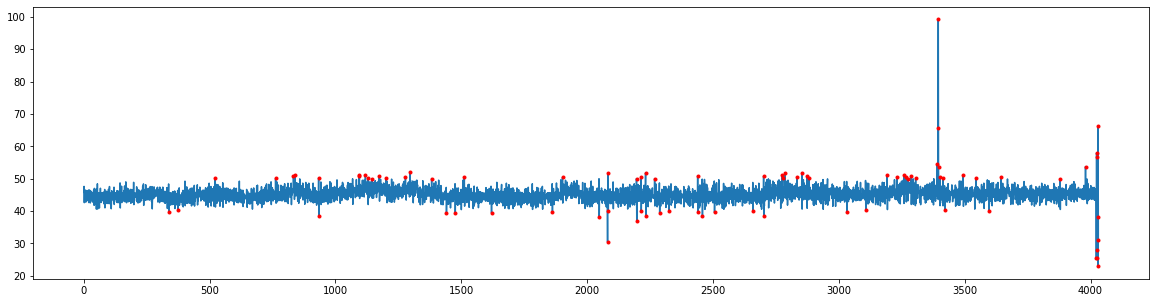

In [57]:
fig, ax = plt.subplots()

ax = df_aws_latency.value.plot(figsize=(20,5))
ax = df_aws_latency.loc[anomalies_iqr_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

## 4.3. Z-Score

### 4.3.1. Artificial Data

In [58]:
df_daily_jumpsup_copy = df_daily_jumpsup.copy()
std = df_daily_jumpsup_copy.value.std()
mean = df_daily_jumpsup_copy.value.mean()
df_daily_jumpsup_copy['z'] = (df_daily_jumpsup_copy.value - mean) / std

<AxesSubplot:>

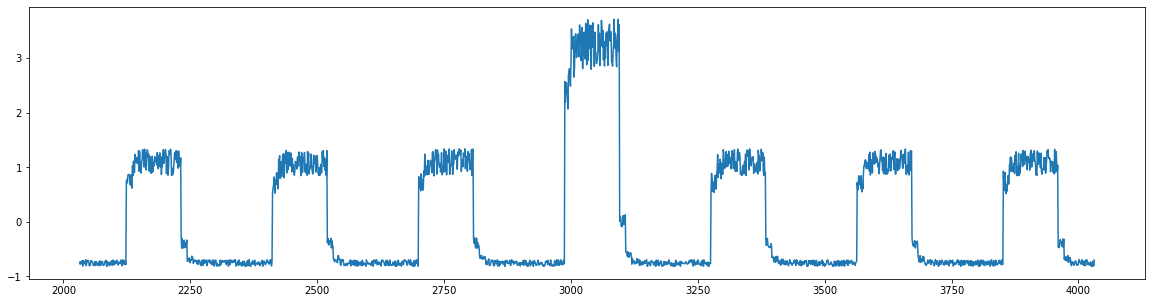

In [59]:
df_daily_jumpsup_copy.tail(2000).z.plot(figsize=(20,5))

In [60]:
z_threshold = 2.5
anomalies_z_a = df_daily_jumpsup_copy[df_daily_jumpsup_copy.z > z_threshold]
anomalies_z_a_mask = df_daily_jumpsup.value > z_threshold
anomalies_z_a.describe()

,value,z
count,102.000000,102.000000
mean,148.747193,3.214462
std,9.533646,0.293954
min,127.261178,2.551977
25%,140.702100,2.966405
50%,149.647462,3.242220
75%,156.770953,3.461861
max,164.947481,3.713970


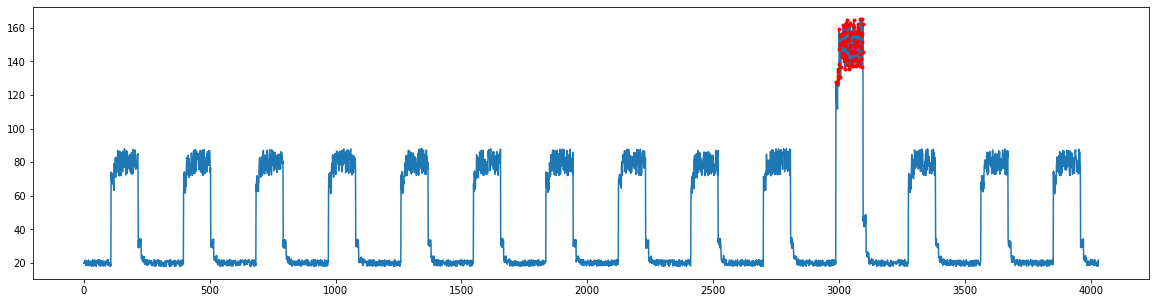

In [61]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup_copy.value.plot(figsize=(20,5))
ax = anomalies_z_a.loc[anomalies_z_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.3.2. Real Data

In [62]:
df_aws_latency_copy = df_aws_latency.copy()
std = df_aws_latency_copy.value.std()
mean = df_aws_latency_copy.value.mean()
df_aws_latency_copy['z'] = (df_aws_latency_copy.value - mean) / std

In [63]:
# df_aws_latency_copy.tail(100).z.plot(figsize=(20,5))

In [64]:
z_threshold_r = 2.5
anomalies_z_r = df_aws_latency_copy[df_aws_latency_copy.z > z_threshold_r]
anomalies_z_r_mask = df_aws_latency_copy.value > z_threshold
anomalies_z_r.describe()

,value,z
count,24.000000,24.000000
mean,55.319250,4.443804
std,10.295113,4.501404
min,50.892000,2.508046
25%,51.018000,2.563138
50%,51.684000,2.854338
75%,53.926000,3.834623
max,99.248000,23.651076


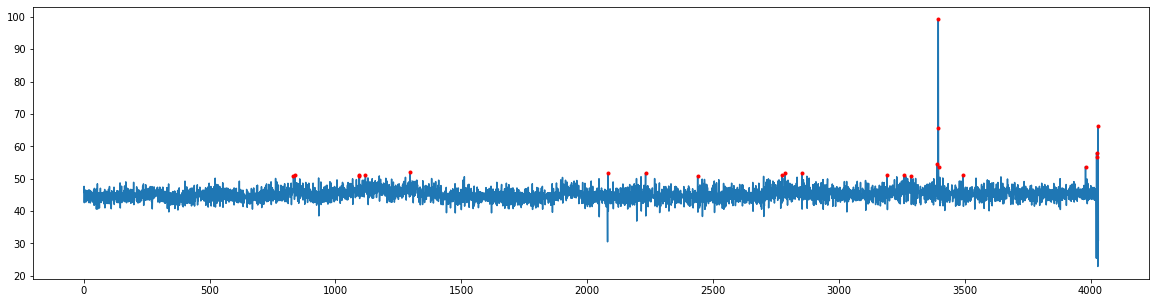

In [65]:
fig, ax = plt.subplots()

ax = df_aws_latency_copy.value.plot(figsize=(20,5))
ax = anomalies_z_r.loc[anomalies_z_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

In [66]:
# AWS "realKnownCause/ec2_request_latency_system_failure.csv"
# data from: https://github.com/numenta/NAB/blob/master/labels/combined_windows.json
anomalies_aws = [
    [
        "2014-03-14 03:31:00.000000",
        "2014-03-14 14:41:00.000000"
    ],
    [
        "2014-03-18 17:06:00.000000",
        "2014-03-19 04:16:00.000000"
    ],
    [
        "2014-03-20 21:26:00.000000",
        "2014-03-21 03:41:00.000000"
    ]
]

In [67]:
mask_aws_latency_anomaly1 = (df_aws_latency_copy['timestamp'] > anomalies_aws[0][0]) & (df_aws_latency_copy['timestamp'] <= anomalies_aws[0][1])
mask_aws_latency_anomaly2 = (df_aws_latency_copy['timestamp'] > anomalies_aws[1][0]) & (df_aws_latency_copy['timestamp'] <= anomalies_aws[1][1])
mask_aws_latency_anomaly3 = (df_aws_latency_copy['timestamp'] > anomalies_aws[2][0]) & (df_aws_latency_copy['timestamp'] <= anomalies_aws[2][1])

In [68]:
print(np.sum(mask_aws_latency_anomaly1))
print(np.sum(mask_aws_latency_anomaly2))
print(np.sum(mask_aws_latency_anomaly3))

134
134
75


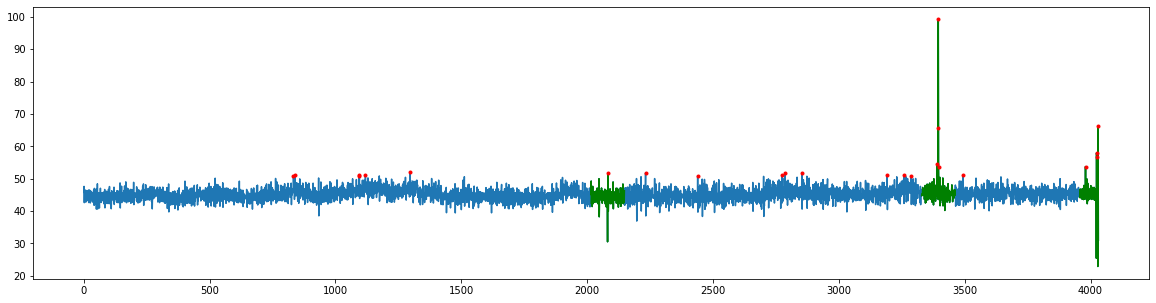

In [69]:
fig, ax = plt.subplots()

ax = df_aws_latency_copy.value.plot(figsize=(20,5))
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly1].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly2].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly3].value.plot(figsize=(20,5), color='green')
ax = anomalies_z_r.loc[anomalies_z_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

## 4.4. Histogram

### 4.4.1. Artificial Data

<AxesSubplot:>

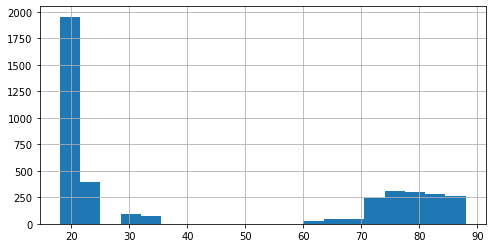

In [70]:
df_small_noise.value.hist(bins=20, figsize=(8,4))

<AxesSubplot:>

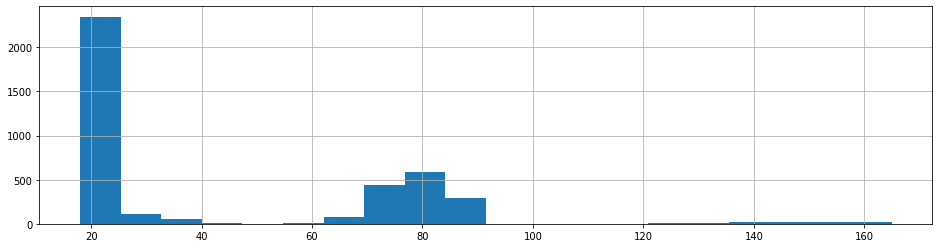

In [71]:
df_daily_jumpsup.value.hist(bins=20, figsize=(16,4))

In [72]:
anomalies_histogram = df_daily_jumpsup[df_daily_jumpsup.value > 120]
anomalies_histogram.describe()

,value
count,106.000000
mean,147.749402
std,10.638715
min,120.468468
25%,140.477747
50%,149.346186
75%,156.683030
max,164.947481


In [73]:
anomalies_z_a_mask = df_daily_jumpsup.value > 120

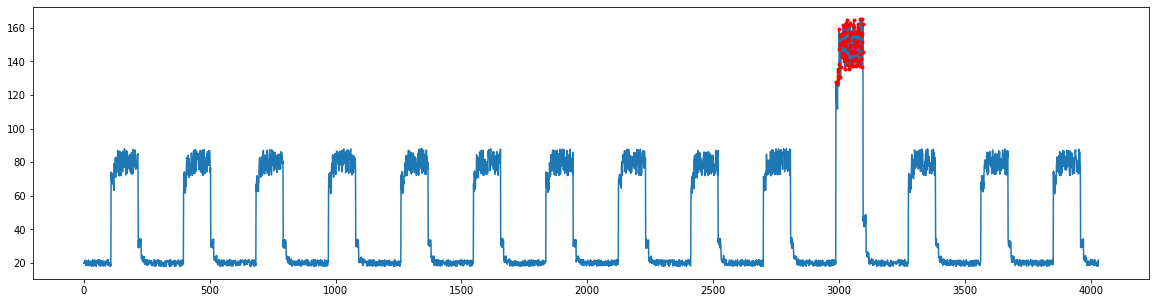

In [74]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup_copy.value.plot(figsize=(20,5))
ax = anomalies_z_a.loc[anomalies_z_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.4.2. Real Data

<AxesSubplot:>

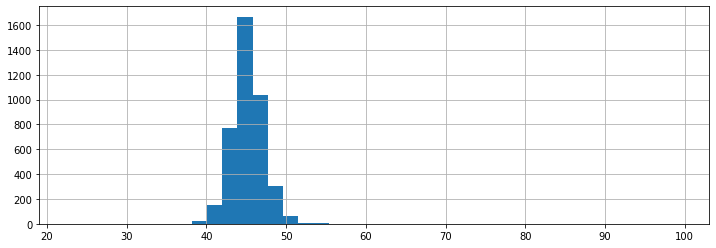

In [75]:
df_aws_latency.value.hist(bins=40, figsize=(12,4))

# 5. Deep-Learning Approach

## 5.1. Prepare Data

In [76]:
def get_values_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

# select values that are not part of anomalous areas
df_aws_latency_train = df_aws_latency_copy.loc[~mask_aws_latency_anomaly1 & 
                                               ~mask_aws_latency_anomaly2 & 
                                               ~mask_aws_latency_anomaly3]


# Get the `value` column from the training dataframe.
training_values_a = get_values_from_df(df_small_noise)
training_values_r = get_values_from_df(df_aws_latency_train)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_values_a, training_mean_a, training_std_a = normalize(training_values_a)
training_values_r, training_mean_r, training_std_r = normalize(training_values_r)
print(len(training_values_a))
print(len(training_values_r))

4032
3689


In [77]:
df_aws_latency_train.head()

,timestamp,value,z
0,2014-03-07 03:41:00,45.868,0.311368
1,2014-03-07 03:46:00,47.606,1.071286
2,2014-03-07 03:51:00,42.580,-1.126267
3,2014-03-07 03:56:00,46.030,0.382200
4,2014-03-07 04:01:00,44.992,-0.071652


<AxesSubplot:>

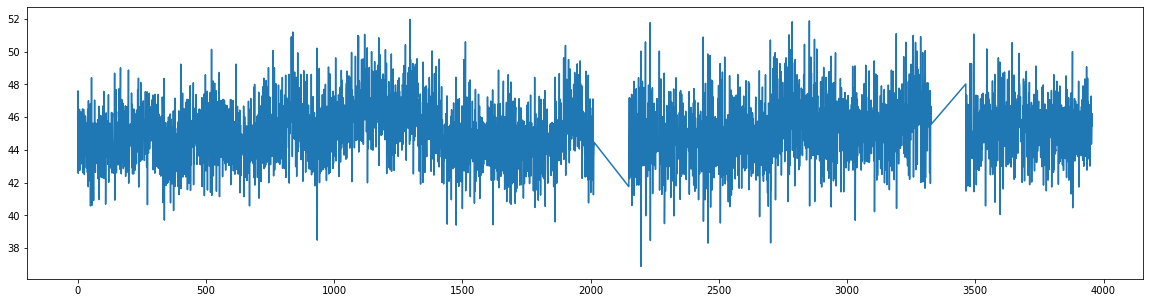

In [78]:
df_aws_latency_train.value.plot(figsize=(20,5))

## 5.2. Prepare sequences

In [79]:
TIME_STEPS_A = 288
TIME_STEPS_R = 134


def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train_a = create_sequences(training_values_a, time_steps=TIME_STEPS_A)
x_train_r = create_sequences(training_values_r, time_steps=TIME_STEPS_R)

print("Training input shape artificial: ", x_train_a.shape)
print("Training input shape real: ", x_train_r.shape)

Training input shape artificial:  (3744, 288, 1)
Training input shape real:  (3555, 134, 1)


## 5.3. Build Models

In [80]:
def create_model(n_steps, n_features, learning_rate=0.001, kernel_size=15, units=25):
    keras.backend.clear_session()
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(n_steps, n_features)),
            layers.Conv1D(filters=32, 
                          kernel_size=kernel_size, 
                          padding='same', 
                          data_format='channels_last',
                          dilation_rate=1, 
                          activation="linear"),
            layers.LSTM(units=units, activation="tanh", name="lstm_1", return_sequences=False),
            layers.RepeatVector(n_steps),
            layers.LSTM(units=units, activation="tanh", name="lstm_2", return_sequences=True),
            layers.Conv1D(filters=32, 
                          kernel_size=kernel_size, 
                          padding='same', 
                          data_format='channels_last',
                          dilation_rate=1, 
                          activation="linear"),
            layers.TimeDistributed(layers.Dense(1, activation='linear'))
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

### 5.3.1. Artificial Data

In [81]:
n_steps_a = x_train_a.shape[1]
n_features_a = x_train_a.shape[2]

# create model based on artificial data
model_a = create_model(n_steps_a, n_features_a)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 288, 32)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5800      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 288, 25)           5100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 288, 32)           12032     
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            33        
Total params: 23,477
Trainable params: 23,477
Non-trainable params: 0
____________________________________________________

### 5.3.2. Real Data

In [82]:
n_steps_r = x_train_r.shape[1]
n_features_r = x_train_r.shape[2]

# create model based on real data
model_r = create_model(n_steps_r, n_features_r, learning_rate=0.01, kernel_size=30, units=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 134, 32)           992       
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 134, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 134, 50)           20200     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 134, 32)           48032     
_________________________________________________________________
time_distributed (TimeDistri (None, 134, 1)            33        
Total params: 85,857
Trainable params: 85,857
Non-trainable params: 0
____________________________________________________

## 5.4. Train Models

In [83]:
def train_model(model, x_train, batch_size=128, patience=50, epochs=200):
    """ use x_train as both the input and the target since this is a reconstruction model. """
    history = model.fit(
        x_train,
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", 
                                          patience=patience, 
                                          mode="min", 
                                          restore_best_weights=True)
        ],
    )
    return history

### 5.4.1. Artificial Data

In [84]:
history_a = train_model(model_a, x_train_a, batch_size=64)

Epoch 1/200
53/53 [==============================] - 6s 42ms/step - loss: 0.9736 - val_loss: 0.9490
Epoch 2/200
53/53 [==============================] - 1s 26ms/step - loss: 0.8926 - val_loss: 0.9057
Epoch 3/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8656 - val_loss: 0.8614
Epoch 4/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8364 - val_loss: 0.9054
Epoch 5/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8628 - val_loss: 0.8808
Epoch 6/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8733 - val_loss: 0.8747
Epoch 7/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8620 - val_loss: 0.8836
Epoch 8/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8215 - val_loss: 0.8304
Epoch 9/200
53/53 [==============================] - 1s 26ms/step - loss: 0.7918 - val_loss: 0.9029
Epoch 10/200
53/53 [==============================] - 1s 25ms/step - loss: 0.8347 - val_loss: 0.8165

53/53 [==============================] - 1s 22ms/step - loss: 0.0430 - val_loss: 0.0453
Epoch 83/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0479 - val_loss: 0.0365
Epoch 84/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0502 - val_loss: 0.0360
Epoch 85/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0405 - val_loss: 0.0480
Epoch 86/200
53/53 [==============================] - 1s 25ms/step - loss: 0.0401 - val_loss: 0.0328
Epoch 87/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0388 - val_loss: 0.0415
Epoch 88/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0446 - val_loss: 0.0439
Epoch 89/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0517 - val_loss: 0.0516
Epoch 90/200
53/53 [==============================] - 1s 25ms/step - loss: 0.0424 - val_loss: 0.0450
Epoch 91/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0393 - val_loss: 0.0322
Epo

53/53 [==============================] - 1s 24ms/step - loss: 0.0267 - val_loss: 0.0219
Epoch 163/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0283 - val_loss: 0.0386
Epoch 164/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0277 - val_loss: 0.0226
Epoch 165/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0393 - val_loss: 0.0358
Epoch 166/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0292 - val_loss: 0.0226
Epoch 167/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0377 - val_loss: 0.0296
Epoch 168/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0283 - val_loss: 0.0251
Epoch 169/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0277 - val_loss: 0.0284
Epoch 170/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0299 - val_loss: 0.0357
Epoch 171/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0254 - val_loss: 0

### 5.4.1. Real Data

In [85]:
history_r = train_model(model_r, x_train_r, batch_size=32, patience=200, epochs=500)

Epoch 1/500
100/100 [==============================] - 5s 22ms/step - loss: 0.9433 - val_loss: 0.8468
Epoch 2/500
100/100 [==============================] - 1s 14ms/step - loss: 0.9083 - val_loss: 0.8433
Epoch 3/500
100/100 [==============================] - 1s 15ms/step - loss: 0.9026 - val_loss: 0.8456
Epoch 4/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8948 - val_loss: 0.8403
Epoch 5/500
100/100 [==============================] - 2s 15ms/step - loss: 0.8868 - val_loss: 0.8411
Epoch 6/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8859 - val_loss: 0.8378
Epoch 7/500
100/100 [==============================] - 1s 14ms/step - loss: 0.8761 - val_loss: 0.8355
Epoch 8/500
100/100 [==============================] - 1s 14ms/step - loss: 0.8739 - val_loss: 0.8335
Epoch 9/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8705 - val_loss: 0.8322
Epoch 10/500
100/100 [==============================] - 1s 14ms/step - loss: 0.869

100/100 [==============================] - 1s 14ms/step - loss: 0.7713 - val_loss: 0.7456
Epoch 81/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7708 - val_loss: 0.7425
Epoch 82/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7681 - val_loss: 0.7440
Epoch 83/500
100/100 [==============================] - 2s 17ms/step - loss: 0.7690 - val_loss: 0.7424
Epoch 84/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7697 - val_loss: 0.7439
Epoch 85/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7683 - val_loss: 0.7427
Epoch 86/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7682 - val_loss: 0.7419
Epoch 87/500
100/100 [==============================] - 2s 15ms/step - loss: 0.7674 - val_loss: 0.7403
Epoch 88/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7680 - val_loss: 0.7409
Epoch 89/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7664 - 

100/100 [==============================] - 1s 14ms/step - loss: 0.7180 - val_loss: 0.7331
Epoch 160/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7167 - val_loss: 0.7204
Epoch 161/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7132 - val_loss: 0.7196
Epoch 162/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7139 - val_loss: 0.7209
Epoch 163/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7149 - val_loss: 0.7184
Epoch 164/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7128 - val_loss: 0.7155
Epoch 165/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7109 - val_loss: 0.7219
Epoch 166/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7107 - val_loss: 0.7185
Epoch 167/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7103 - val_loss: 0.7227
Epoch 168/500
100/100 [==============================] - 1s 14ms/step - loss: 

Epoch 238/500
100/100 [==============================] - 2s 16ms/step - loss: 0.6536 - val_loss: 0.7427
Epoch 239/500
100/100 [==============================] - 2s 16ms/step - loss: 0.6548 - val_loss: 0.7545
Epoch 240/500
100/100 [==============================] - 2s 16ms/step - loss: 0.6562 - val_loss: 0.7735
Epoch 241/500
100/100 [==============================] - 2s 16ms/step - loss: 0.6571 - val_loss: 0.7412
Epoch 242/500
100/100 [==============================] - 2s 16ms/step - loss: 0.6777 - val_loss: 0.7340
Epoch 243/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6617 - val_loss: 0.7385
Epoch 244/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6638 - val_loss: 0.7590
Epoch 245/500
100/100 [==============================] - 2s 15ms/step - loss: 0.6591 - val_loss: 0.7283
Epoch 246/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6496 - val_loss: 0.7355
Epoch 247/500
100/100 [==============================] - 1s 14ms

Epoch 317/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6386 - val_loss: 0.7671
Epoch 318/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6100 - val_loss: 0.7525
Epoch 319/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5834 - val_loss: 0.7784
Epoch 320/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5824 - val_loss: 0.7492
Epoch 321/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5769 - val_loss: 0.7692
Epoch 322/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5789 - val_loss: 0.7700
Epoch 323/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5963 - val_loss: 0.7694
Epoch 324/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5862 - val_loss: 0.7897
Epoch 325/500
100/100 [==============================] - 1s 14ms/step - loss: 0.5753 - val_loss: 0.7721
Epoch 326/500
100/100 [==============================] - 1s 14ms

## 5.5. Evaluate Training

In [86]:
def plot_training_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()

### 5.5.1. Artificial Data

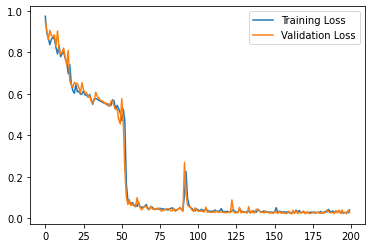

In [87]:
plot_training_history(history_a)

### 5.5.2. Real Data

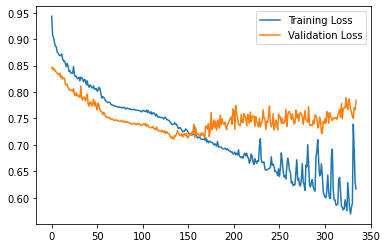

In [88]:
plot_training_history(history_r)

## 5.6. Anomaly Detection

In [89]:
def find_anomaly_threshold(model, x_train):
    # Get train MAE loss.
    x_train_pred = model.predict(x_train)
    diff = np.abs(x_train_pred - x_train)
    train_mae_loss = np.percentile(diff, axis=1, q=50)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.    
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)
    return x_train_pred, threshold

### 5.6.1. Artificial Data

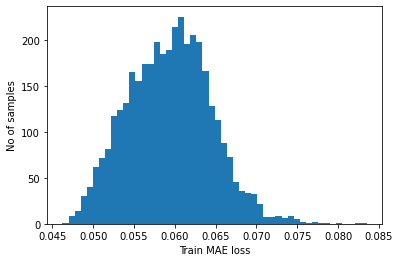

Reconstruction error threshold:  0.08351738305871148


In [106]:
x_train_pred_a, threshold_a = find_anomaly_threshold(model_a, x_train_a)

### 5.6.2. Real Data

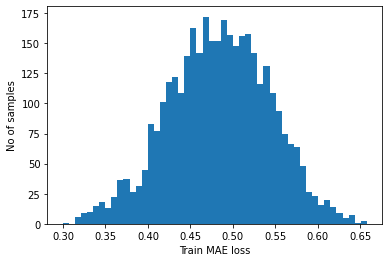

Reconstruction error threshold:  0.6578877144656996


In [91]:
x_train_pred_r, threshold_r = find_anomaly_threshold(model_r, x_train_r)

## 5.7. Compare Reconstruction

### 5.7.1. Artificial Data

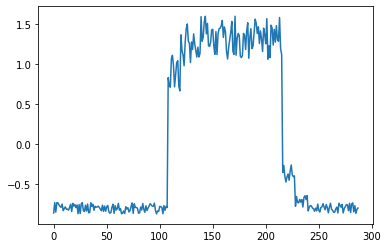

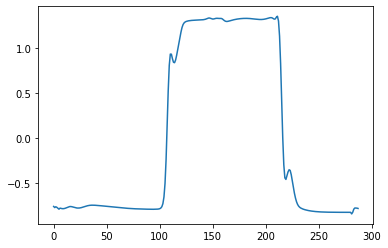

In [92]:
# Checking how the first sequence is learnt
plt.plot(x_train_a[0])
plt.show()
plt.plot(x_train_pred_a[0])
plt.show()

### 5.7.2. Real Data

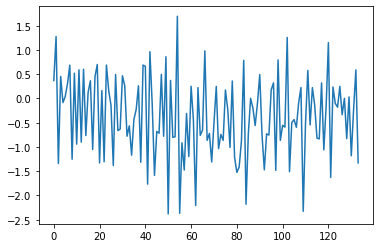

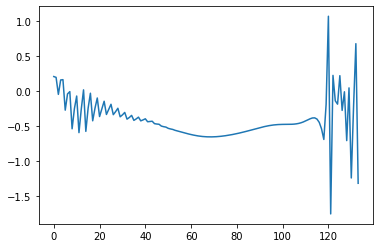

In [93]:
# Checking how the first sequence is learnt
plt.plot(x_train_r[0])
plt.show()
plt.plot(x_train_pred_r[0])
plt.show()

## 5.8. Prepare Test Data

In [94]:
def prepare_test_data(model, df, training_mean, training_std, threshold, time_steps):
    def normalize_test(values, mean, std):
        values -= mean
        values /= std
        return values

    test_values = get_values_from_df(df)
    test_values = normalize_test(test_values, training_mean, training_std)
    plt.plot(test_values.tolist())
    plt.show()

    # Create sequences from test values.
    x_test = create_sequences(test_values, time_steps)
    print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the samples which are anomalies.
    anomalies = (test_mae_loss > threshold).tolist()
#     print(test_mae_loss)
    print("Number of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    return test_values, anomalies

### 5.8.1. Artificial Data

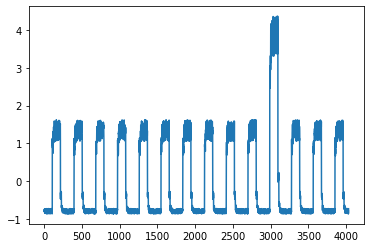

Test input shape:  (3744, 288, 1)


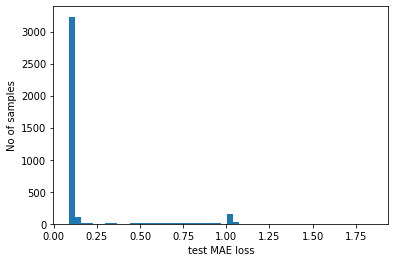

Number of anomaly samples:  3744
Indices of anomaly samples:  (array([   0,    1,    2, ..., 3741, 3742, 3743]),)


In [95]:
test_values_a, anomalies_a = prepare_test_data(model_a, df_daily_jumpsup, training_mean_a, training_std_a, threshold_a, time_steps=TIME_STEPS_A)

### 5.8.2. Real Data

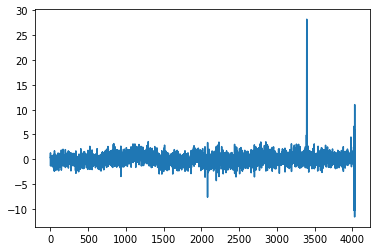

Test input shape:  (3898, 134, 1)


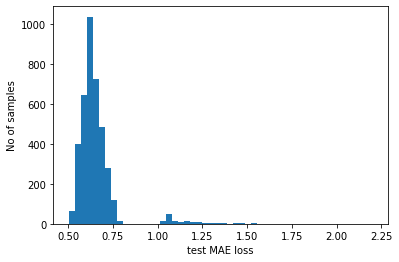

Number of anomaly samples:  1286
Indices of anomaly samples:  (array([ 907,  908,  909, ..., 3895, 3896, 3897]),)


In [96]:
test_values_r, anomalies_r = prepare_test_data(model_r, df_aws_latency_copy, training_mean_r, training_std_r, threshold_r, time_steps=TIME_STEPS_R)

## 5.9. Plot Anomalies

In [97]:
def plot_anomalies(data, anomalies, test_values, time_steps=100):
    anomalous_data_indices = []
    for data_idx in range(time_steps - 1, len(test_values) - time_steps + 1):
        time_series_idxs = range(data_idx - time_steps + 1, data_idx)
        if anomalies:
            chunk = []
            for j in time_series_idxs:
                if j < len(anomalies):
                    chunk.append(anomalies[j])
            if all(chunk):
                anomalous_data_indices.append(data_idx)
    df_subset = data.iloc[anomalous_data_indices, :]
    
    plt.figure(figsize=(20, 5))
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)

    dates = data["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = data["value"].to_list()
    plt.plot(dates, values, label="test data")

    dates_anomalies = df_subset["timestamp"].to_list()
    dates_anomalies = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates_anomalies]
    values_anomalies = df_subset["value"].to_list()
    plt.plot(dates_anomalies, values_anomalies, label="anomalies", color="red", marker='o', linestyle='')

    plt.legend()
    plt.show()

### 5.9.1. Artificial Data

In [98]:
len(df_daily_jumpsup)

4032

In [99]:
len(anomalies_a)

3744

In [100]:
len(test_values_a)

4032

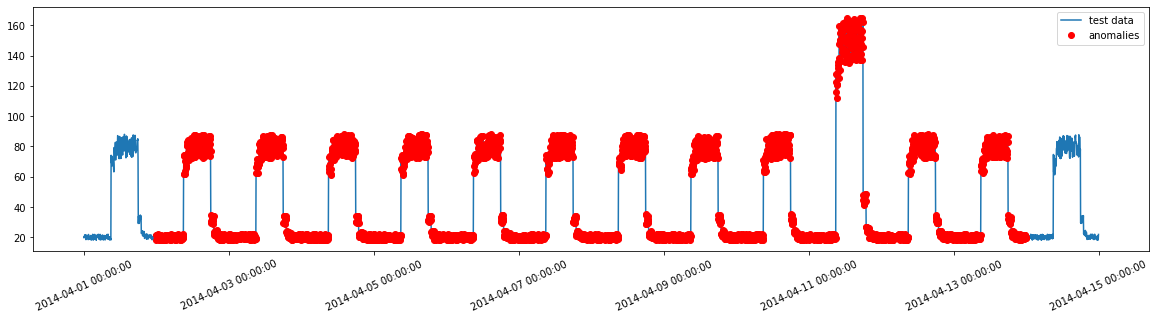

In [104]:
plot_anomalies(df_daily_jumpsup, anomalies_a, test_values_a, time_steps=TIME_STEPS_A)

### 5.9.2. Real Data

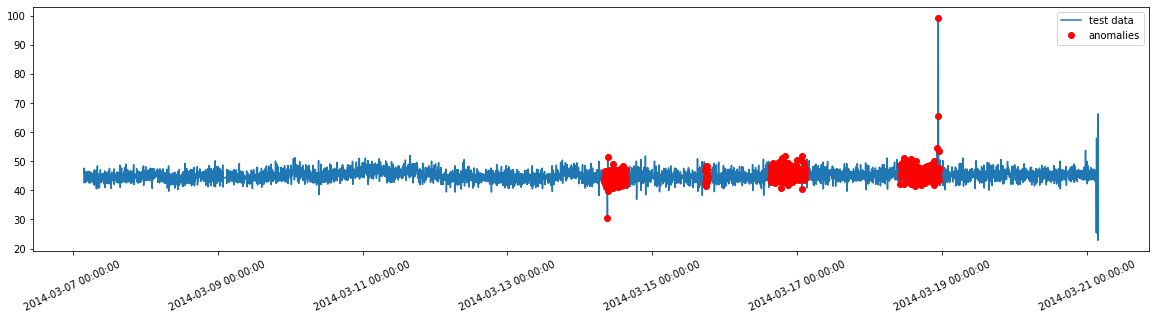

In [105]:
plot_anomalies(df_aws_latency_copy, anomalies_r, test_values_r, time_steps=120)

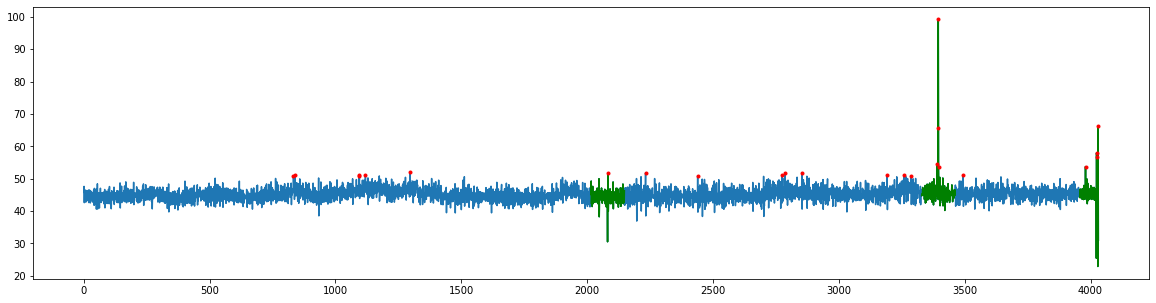

In [103]:
fig, ax = plt.subplots()

ax = df_aws_latency_copy.value.plot(figsize=(20,5))
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly1].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly2].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly3].value.plot(figsize=(20,5), color='green')
ax = anomalies_z_r.loc[anomalies_z_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

# plt.legend(loc='best')
plt.show()

# 6. Reconstruct Data